In [1]:
# This notebook walks through the process of using PCA to improve logistic regression.
# This is adapted from a Kaggle dataset (https://www.kaggle.com/stevebroll/logistic-regression-model-using-pca-components/notebook)

# Import necessary Python libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()  # for plot styling

from sklearn.preprocessing import scale # center to the mean and component wise scale to unit variance.
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import sklearn.pipeline as skpl # convenient module for calculating PCs and using them in logistic regression

In [2]:
# Reading in the breast mass data
df = pd.read_csv('Data/cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# Remove the id and unnamed cols
X = df.drop(['id', 'Unnamed: 32'], axis=1)
X

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.990,10.38,122.80,1001.0,0.11840,0.27760,0.300100,0.147100,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.71190,0.26540,0.4601,0.11890
1,M,20.570,17.77,132.90,1326.0,0.08474,0.07864,0.086900,0.070170,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.24160,0.18600,0.2750,0.08902
2,M,19.690,21.25,130.00,1203.0,0.10960,0.15990,0.197400,0.127900,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.45040,0.24300,0.3613,0.08758
3,M,11.420,20.38,77.58,386.1,0.14250,0.28390,0.241400,0.105200,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.68690,0.25750,0.6638,0.17300
4,M,20.290,14.34,135.10,1297.0,0.10030,0.13280,0.198000,0.104300,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.40000,0.16250,0.2364,0.07678
5,M,12.450,15.70,82.57,477.1,0.12780,0.17000,0.157800,0.080890,0.2087,...,15.470,23.75,103.40,741.6,0.17910,0.52490,0.53550,0.17410,0.3985,0.12440
6,M,18.250,19.98,119.60,1040.0,0.09463,0.10900,0.112700,0.074000,0.1794,...,22.880,27.66,153.20,1606.0,0.14420,0.25760,0.37840,0.19320,0.3063,0.08368
7,M,13.710,20.83,90.20,577.9,0.11890,0.16450,0.093660,0.059850,0.2196,...,17.060,28.14,110.60,897.0,0.16540,0.36820,0.26780,0.15560,0.3196,0.11510
8,M,13.000,21.82,87.50,519.8,0.12730,0.19320,0.185900,0.093530,0.2350,...,15.490,30.73,106.20,739.3,0.17030,0.54010,0.53900,0.20600,0.4378,0.10720
9,M,12.460,24.04,83.97,475.9,0.11860,0.23960,0.227300,0.085430,0.2030,...,15.090,40.68,97.65,711.4,0.18530,1.05800,1.10500,0.22100,0.4366,0.20750


In [4]:
# Create a dummy variable to represent categorical data
print(pd.get_dummies(X['diagnosis']).head(1))

X['diagnosis_dummies'] = pd.get_dummies(X['diagnosis']).iloc[:,1]# extract Malignant dummy category to dataframe

   B  M
0  0  1


In [5]:
# Make correlation matrix 
datacorr = X.corr()
print(datacorr.shape)

(31, 31)


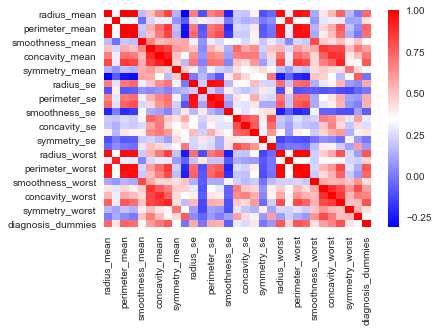

In [6]:
# Create heatmap of correlation matrix
sns.heatmap(datacorr, cmap = 'bwr')
plt.show()

# Red squares off the main diagonal imply multicollinearity

In [7]:
# Store response variable
y = X['diagnosis_dummies']

# Prepare data matrix
X = scale(X.drop(['diagnosis','diagnosis_dummies'], 1).astype(float))
print(X) # independent variables

[[ 1.09706398 -2.07333501  1.26993369 ...,  2.29607613  2.75062224
   1.93701461]
 [ 1.82982061 -0.35363241  1.68595471 ...,  1.0870843  -0.24388967
   0.28118999]
 [ 1.57988811  0.45618695  1.56650313 ...,  1.95500035  1.152255
   0.20139121]
 ..., 
 [ 0.70228425  2.0455738   0.67267578 ...,  0.41406869 -1.10454895
  -0.31840916]
 [ 1.83834103  2.33645719  1.98252415 ...,  2.28998549  1.91908301
   2.21963528]
 [-1.80840125  1.22179204 -1.81438851 ..., -1.74506282 -0.04813821
  -0.75120669]]


In [10]:
# Perform PCA via the sklearn PCA library and generate score matrix, Z
pca = PCA()
Z = pca.fit_transform(X)
Z

array([[  9.19283683e+00,   1.94858307e+00,  -1.12316616e+00, ...,
         -3.39144536e-02,   4.56477199e-02,  -4.71692081e-02],
       [  2.38780180e+00,  -3.76817174e+00,  -5.29292687e-01, ...,
          3.26241827e-02,  -5.68742432e-03,  -1.86787626e-03],
       [  5.73389628e+00,  -1.07517380e+00,  -5.51747593e-01, ...,
          4.70258247e-02,   3.14589659e-03,   7.50534755e-04],
       ..., 
       [  1.25617928e+00,  -1.90229671e+00,   5.62730526e-01, ...,
         -2.57775589e-03,   6.70621179e-03,   3.77041667e-03],
       [  1.03747941e+01,   1.67201011e+00,  -1.87702933e+00, ...,
         -6.80863833e-02,  -8.41632764e-02,  -2.37828222e-02],
       [ -5.47524330e+00,  -6.70636791e-01,   1.49044308e+00, ...,
         -9.51587894e-03,  -6.09131090e-02,  -1.94755854e-02]])

In [11]:
# Find and print eigenvalues, prop of variance explained, and cumulative prop explained for PCs
eig_values = pca.explained_variance_
percent_var = pca.explained_variance_ratio_
cum_var = np.cumsum(percent_var)
print("Eigenvalues: ", eig_values)
print("Prop of variance explained: ", percent_var) # prop of variance explained
print("Cumulative prop explained: ", cum_var) # cumulative

# Find and print matrix of PCs (PCs are column vectors)
V = pca.components_.T
print("Loadings matrix:")
print(V.round(2)) # same as loadings matrix

# first 10 PCs explain 95% of the variance in the data

Eigenvalues:  [  1.33049908e+01   5.70137460e+00   2.82291016e+00   1.98412752e+00
   1.65163324e+00   1.20948224e+00   6.76408882e-01   4.77456255e-01
   4.17628782e-01   3.51310875e-01   2.94433153e-01   2.61621161e-01
   2.41782421e-01   1.57286149e-01   9.43006956e-02   8.00034045e-02
   5.95036135e-02   5.27114222e-02   4.95647002e-02   3.12142606e-02
   3.00256631e-02   2.74877113e-02   2.43836914e-02   1.80867940e-02
   1.55085271e-02   8.19203712e-03   6.91261258e-03   1.59213600e-03
   7.50121413e-04   1.33279057e-04]
Prop of variance explained:  [  4.42720256e-01   1.89711820e-01   9.39316326e-02   6.60213492e-02
   5.49576849e-02   4.02452204e-02   2.25073371e-02   1.58872380e-02
   1.38964937e-02   1.16897819e-02   9.79718988e-03   8.70537901e-03
   8.04524987e-03   5.23365745e-03   3.13783217e-03   2.66209337e-03
   1.97996793e-03   1.75395945e-03   1.64925306e-03   1.03864675e-03
   9.99096464e-04   9.14646751e-04   8.11361259e-04   6.01833567e-04
   5.16042379e-04   2.72

In [12]:
# Run PCR with first 10 components
pca_new = PCA(n_components=10) #only include first 10 PCs
logreg = LogisticRegression()#empty model space

# Create pipeline from pca to logregression space
pipeline = skpl.Pipeline([('pca', pca_new), ('logistic', logreg)]) 

In [13]:
# Test if model useful with leave one out cross validation
predMalignantRight = 0 #create count variables
predMalignantWrong = 0
predBenignRight = 0
predBenignWrong = 0

In [15]:
for i in range(0,569): #run through each row in data set
    trainX = np.delete(X, i, 0) #train model with predictor dataframe, remove single row
    trainy = y.drop(i,0) #train model with response array, remove single row
    testX = X[i,:].reshape(1,30) #Removed row will be test predictor
    testy = y[i] #Removed value will be test response
    fit = pipeline.fit(trainX, trainy) #fit model
    prediction = pipeline.predict(testX) #test model with left out value
    if prediction == 1 and testy == 1:
        predMalignantRight += 1
    elif prediction == 1 and testy == 0:
        predMalignantWrong += 1
    elif prediction == 0 and testy == 1:
        predBenignWrong += 1
    else:
        predBenignRight += 1

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

In [16]:
print(predMalignantRight,predMalignantWrong,predBenignRight,predBenignWrong)

204 4 353 8


In [17]:
###Now sensitivity and specificity will be calculated
mr,mw = float(predMalignantRight), float(predMalignantWrong)
bw,br = float(predBenignWrong), float(predBenignRight)
sens = mr/(mr+mw) #calculate sensitivity, or rate of correctly predicting disease
spec = br/(br+bw) #calculate specificity, or rate of correctly predicting no disease
acc = (sens + spec)/2 #calculate balanced accuracy, or average of sensitivty and specificity
mis = (mw+bw)/(mw+bw+mr+br) #calculate misclassification rate

In [18]:
###create series of values, then convert to dataframe to print as table
outputseries = pd.Series([sens,spec,acc,mis],index=['Sensitivity','Specificity','Balanced Accuracy','Misclassification rate'])
outputdf = pd.DataFrame(outputseries)
outputdf.columns = [''] #blank header name
outputdf.head()

,
Sensitivity,0.980769
Specificity,0.977839
Balanced Accuracy,0.979304
Misclassification rate,0.021090
